# Real Estate Market Data Exploration in Toulouse and its suburbs
<img src="toulouse.png">

## Description of project and data overview

The objective is to perform real estate data exploration near the city of Toulouse. The Dataset is a 5-years real data history of houses and apartments sales transactions in Toulouse and its suburbs. The dataset contains details for each transaction:

- SaleDate : The date of the transaction
- City: The correspondant City
- PostCode: The Postal code of the real estate good
- ResidenceType: the type of residence, can be an appartment or a House
- SaleType: Is it a normal sale or a Sale before completion
- LandArea: Area of the land around the house
- LivingArea: Area of the appart/house
- NbRooms: the number of rooms
- Price

We use Spark for this analysis because you should be able to apply our analysis to a dataset with the entire real estate market in France for instance (big data file).



## Data acquisition

First, we need to create/get a spark sqlContext in order to use spark

In [1]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("RealEstate").getOrCreate()

The next step consists in building the Structure of our spark DataFrame, assigning to each column the right type of its data:

In [2]:
# We want to use the following schema to import our dataframe (with new columns names and suitable datatypes)

from pyspark.sql.types import *

sales_schema =StructType ( [StructField("SaleDate", DateType(), True),
                           StructField("SaleType", StringType(), True),
                           StructField("Price", DoubleType(), True),
                           StructField("PostCode", StringType(), True),
                           StructField("City", StringType(), True),
                           StructField("NbRooms", IntegerType(), True),
                           StructField("NbLots", IntegerType(), True),
                           StructField("ResidenceType", StringType(), True),
                           StructField("LivingArea", IntegerType(), True),
                           StructField("LandArea", IntegerType(), True)]
                            )    

Now we import the file:

In [3]:
# we read sales.csv file with the previous defined schema

tls_hse = spark.read.csv('project_data_real_estate_toulouse_and_suburbs.csv', header=True, sep=';', dateFormat='dd/MM/YYYY', schema=sales_schema)

tls_hse.show(5)

+----------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType|   Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
|2019-01-15|    SALE| 95000.0|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|2019-01-21|    SALE|261700.0|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|2019-01-03|    SALE|101000.0|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|2019-01-11|    SALE| 59500.0|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|2019-01-15|    SALE|179000.0|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
+----------+--------+--------+--------+-------------------+-------+------+-------------+----------+--------+
only showing top 5 

## Data Overview

Some information about our df

In [4]:
tls_hse.printSchema()

root
 |-- SaleDate: date (nullable = true)
 |-- SaleType: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- PostCode: string (nullable = true)
 |-- City: string (nullable = true)
 |-- NbRooms: integer (nullable = true)
 |-- NbLots: integer (nullable = true)
 |-- ResidenceType: string (nullable = true)
 |-- LivingArea: integer (nullable = true)
 |-- LandArea: integer (nullable = true)



We can see that all our 10 column are having their good data type. Now let's see how many transactions we have in the hole dataset

In [5]:
# what is the total number of sales orders of the company ?

total_number_sales = tls_hse.count()

total_number_sales

80118

In [6]:
# what is the gross sales (total of all sales) of the company ?

gross_sales_df = tls_hse.agg({'Price':'sum'})

gross_sales_df.show()

+--------------+
|    sum(Price)|
+--------------+
|4.257333619E10|
+--------------+



In [7]:
# what is the average sales price(total of all sales) ?

gross_sales_df = tls_hse.agg({'Price':'avg'})

gross_sales_df.show()

+-----------------+
|       avg(Price)|
+-----------------+
|552147.5415342714|
+-----------------+



We notice that we have 80118 Transactions with a total sum around 42.57 Billion euros. Knowing that our dataframe is completly clean, no need to do other checking operations such as dropNA, we can directly start our exploration

### Gross sales per cities

In [9]:
from pyspark.sql.functions import col
dates = ("2014-01-01",  "2015-31-12")

# what is the gross sales (sum of all sales) per City ?

gross_sales_city_2015 = tls_hse.where(col('SaleDate').between(*dates)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)

gross_sales_city_2015.show()

#tls_hse.where(col('SaleDate').between(*dates)).show(truncate=False)

+--------------------+-------------+
|                City|   sum(Price)|
+--------------------+-------------+
|            TOULOUSE|1.28098546E10|
|          SAINT-JEAN| 7.19165149E8|
|             BLAGNAC|  5.1947061E8|
|              PIBRAC| 3.23408663E8|
|          AUCAMVILLE| 3.01278636E8|
|RAMONVILLE-SAINT-...| 2.74841647E8|
|               MURET| 1.66269609E8|
|       TOURNEFEUILLE| 1.62605314E8|
|  PLAISANCE DU TOUCH| 1.53310355E8|
|           COLOMIERS| 1.06201156E8|
| VILLENEUVE TOLOSANE| 1.02078218E8|
|               BALMA|  7.9680285E7|
|    CASTANET TOLOSAN|  7.3668185E7|
|             CUGNAUX|   6.195026E7|
|SAINT-ORENS-DE-GA...|  4.9860287E7|
|             L UNION|  4.1453685E7|
|            LEGUEVIN|  2.7697952E7|
|           BEAUZELLE|   2.624278E7|
|  PORTET SUR GARONNE|  2.2025814E7|
|    VIEILLE TOULOUSE|   2.029084E7|
+--------------------+-------------+
only showing top 20 rows



In [10]:
# what is the gross sales (avg of all sales) per City in 2015?

dates = ("2014-01-01",  "2015-31-12")
avg_sales_city_2015 = tls_hse.where(col('SaleDate').between(*dates)).groupBy('City').agg({'Price':'avg'}).orderBy('city', ascending=False)

avg_sales_city_2015.show()

+--------------------+------------------+
|                City|        avg(Price)|
+--------------------+------------------+
| VILLENEUVE TOLOSANE| 667177.8954248365|
|    VIEILLE TOULOUSE| 563634.4444444445|
|       TOURNEFEUILLE|252885.40279937792|
|            TOULOUSE|1141088.0634241938|
|SAINT-ORENS-DE-GA...|215845.39826839828|
|          SAINT-JEAN|  3168128.40969163|
|RAMONVILLE-SAINT-...| 875291.8694267516|
|   QUINT-FONSEGRIVES|216447.32258064515|
|  PORTET SUR GARONNE|215939.35294117648|
|  PLAISANCE DU TOUCH| 594226.1821705427|
|              PIBRAC|2360647.1751824818|
|               MURET| 557951.7080536913|
|            LEGUEVIN|205170.01481481481|
|              LABEGE|231833.92592592593|
|             L UNION| 249720.9939759036|
|          FENOUILLET|178800.24489795917|
|          ESCALQUENS|         243158.16|
|             CUGNAUX|196667.49206349207|
|        CORNEBARRIEU|219340.58695652173|
|           COLOMIERS| 214547.7898989899|
+--------------------+------------

In [11]:
# what is the gross sales (avg of all sales) per City in 2016, 2017, 2018, 2019 and 2020?

y2016 = ("2016-01-01",  "2016-31-12")
y2017 = ("2017-01-01",  "2017-31-12")
y2018 = ("2018-01-01",  "2018-31-12")
y2019 = ("2019-01-01",  "2019-31-12")
y2020 = ("2020-01-01",  "2020-31-12")
avg_sales_city_2016 = tls_hse.where(col('SaleDate').between(*y2016)).groupBy('City').agg({'Price':'avg'}).orderBy('City', ascending=False)
avg_sales_city_2017 = tls_hse.where(col('SaleDate').between(*y2017)).groupBy('City').agg({'Price':'avg'}).orderBy('City', ascending=False)
avg_sales_city_2018 = tls_hse.where(col('SaleDate').between(*y2018)).groupBy('City').agg({'Price':'avg'}).orderBy('City', ascending=False)
avg_sales_city_2019 = tls_hse.where(col('SaleDate').between(*y2019)).groupBy('City').agg({'Price':'avg'}).orderBy('City', ascending=False)
avg_sales_city_2020 = tls_hse.where(col('SaleDate').between(*y2020)).groupBy('City').agg({'Price':'avg'}).orderBy('City', ascending=False)

gross_sales_city_2016 = tls_hse.where(col('SaleDate').between(*y2016)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)
gross_sales_city_2017 = tls_hse.where(col('SaleDate').between(*y2017)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)
gross_sales_city_2018 = tls_hse.where(col('SaleDate').between(*y2018)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)
gross_sales_city_2019 = tls_hse.where(col('SaleDate').between(*y2019)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)
gross_sales_city_2020 = tls_hse.where(col('SaleDate').between(*y2020)).groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)


avg_sales_city_2019.show()

+--------------------+------------------+
|                City|        avg(Price)|
+--------------------+------------------+
| VILLENEUVE TOLOSANE|210984.61538461538|
|    VIEILLE TOULOUSE|          534512.5|
|       TOURNEFEUILLE| 326804.1844660194|
|            TOULOUSE| 694309.7682414049|
|SAINT-ORENS-DE-GA...| 343287.5964912281|
|          SAINT-JEAN| 210550.7837837838|
|RAMONVILLE-SAINT-...|209334.61956521738|
|   QUINT-FONSEGRIVES| 314951.6129032258|
|  PORTET SUR GARONNE|          177012.5|
|  PLAISANCE DU TOUCH| 270194.3469387755|
|              PIBRAC| 380498.6206896552|
|               MURET|177423.07692307694|
|            LEGUEVIN|200743.69047619047|
|              LABEGE|          358325.0|
|             L UNION|132507.47727272726|
|          FENOUILLET|130011.30952380953|
|          ESCALQUENS|215524.26315789475|
|             CUGNAUX|193282.38372093023|
|        CORNEBARRIEU|226298.98039215687|
|           COLOMIERS|189428.87861271677|
+--------------------+------------

In [12]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

def barchart1(top_10):
    pd_df = pd.DataFrame(top_10, columns = ['City','avg(Price)']).sort_values('avg(Price)', ascending = False) 
    
    plt.figure(figsize = (15,9))
    chart = sb.barplot(data=pd_df, x='City', y='avg(Price)', order=pd_df['City'])
    chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation = 80,
    horizontalalignment = 'right',
    fontweight = 'light',
    fontsize = 'large',
    )
    
    plt.show()

### Average sales price in 2015

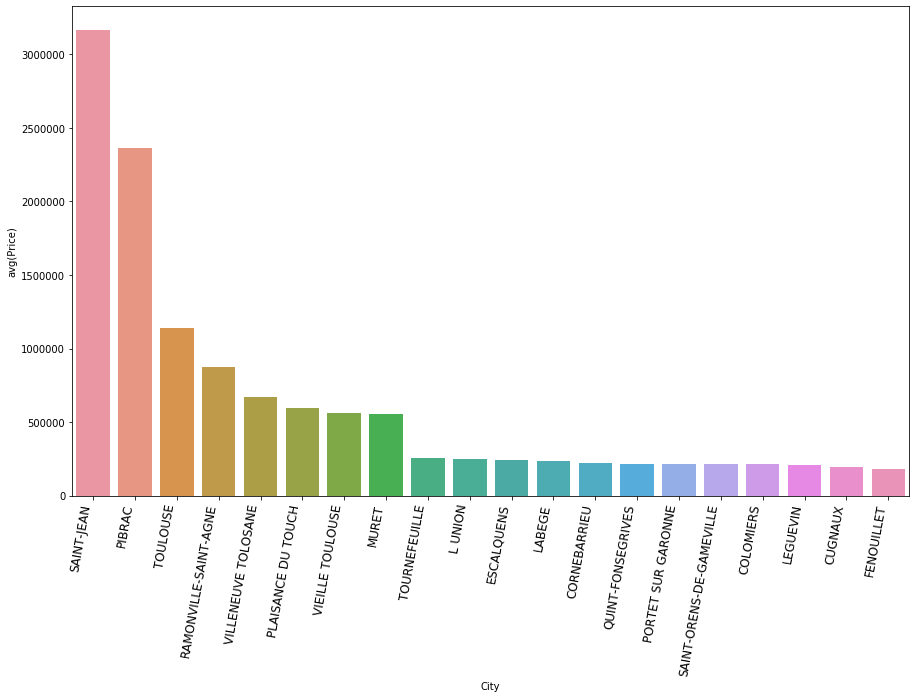

In [13]:
barchart1(avg_sales_city_2015.take(20))

We observe that Saint-Jean and Pibrac are Outliers there because they are having a very high average price, more than 2.3 million euros, which is huge compare to the average price wich is around 550 Thousands euros.

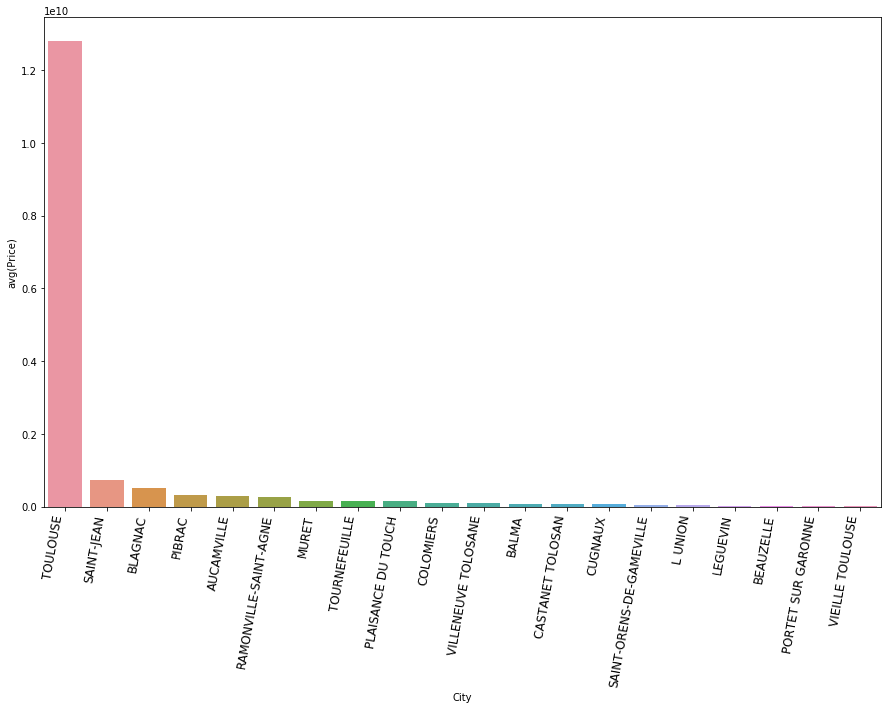

In [14]:
barchart1(gross_sales_city_2015.take(20))

### Average sales price in 2016

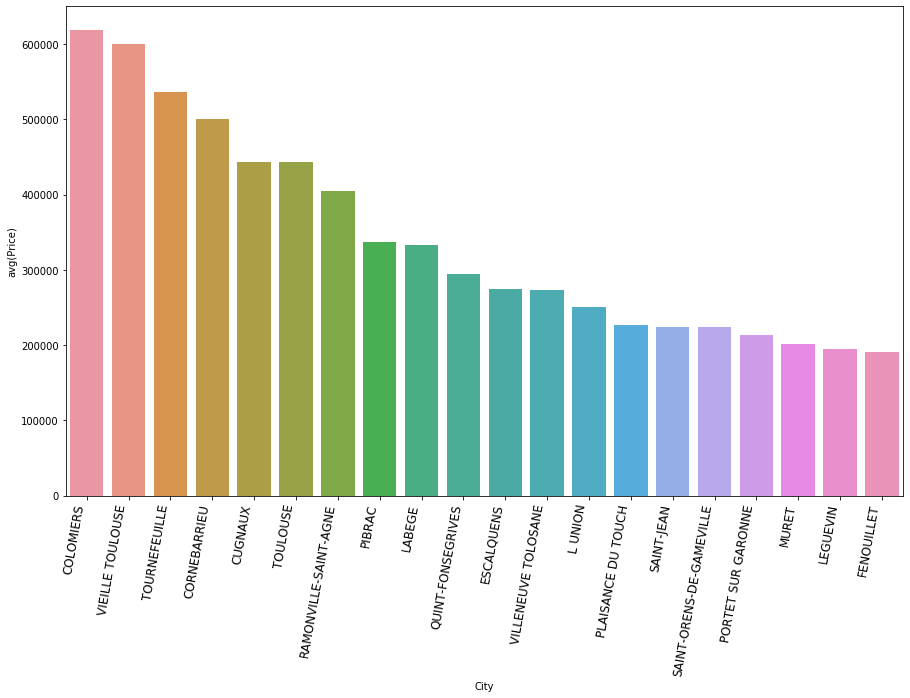

In [15]:
barchart1(avg_sales_city_2016.take(20))

In 2016 the sales price the sales where more or less close to the average

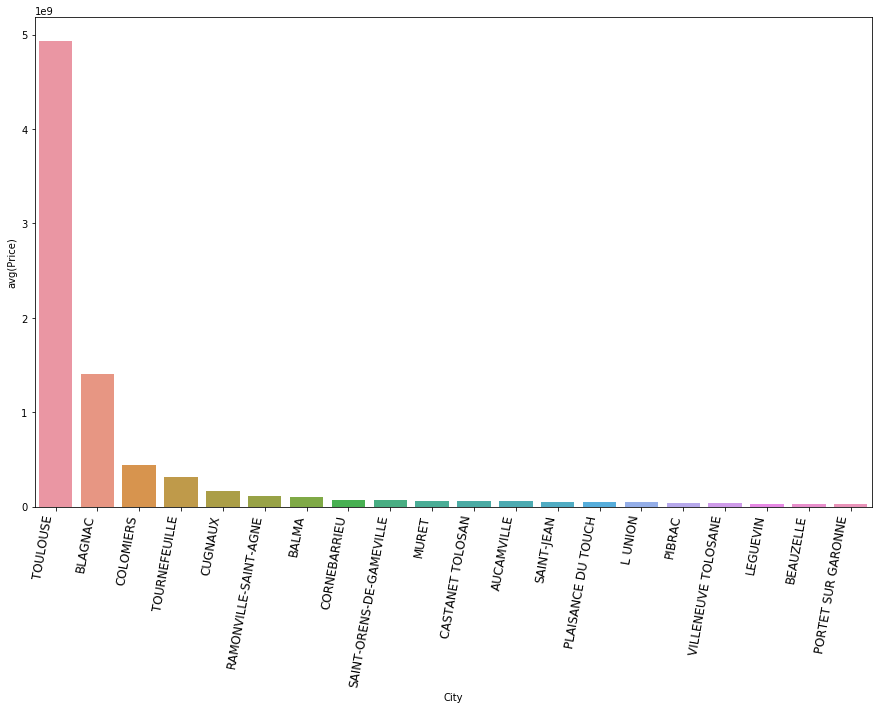

In [16]:
barchart1(gross_sales_city_2016.take(20))

### Average sales price in 2017

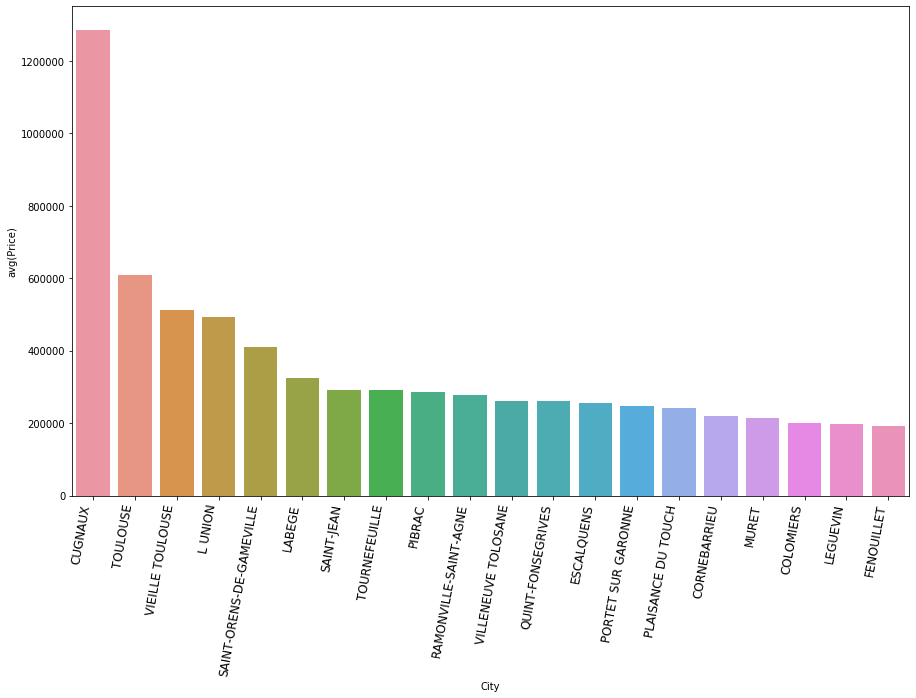

In [17]:
barchart1(avg_sales_city_2017.take(20))

Here is another Outlier, at Cugnaux, whose price was 2 times greater than the average

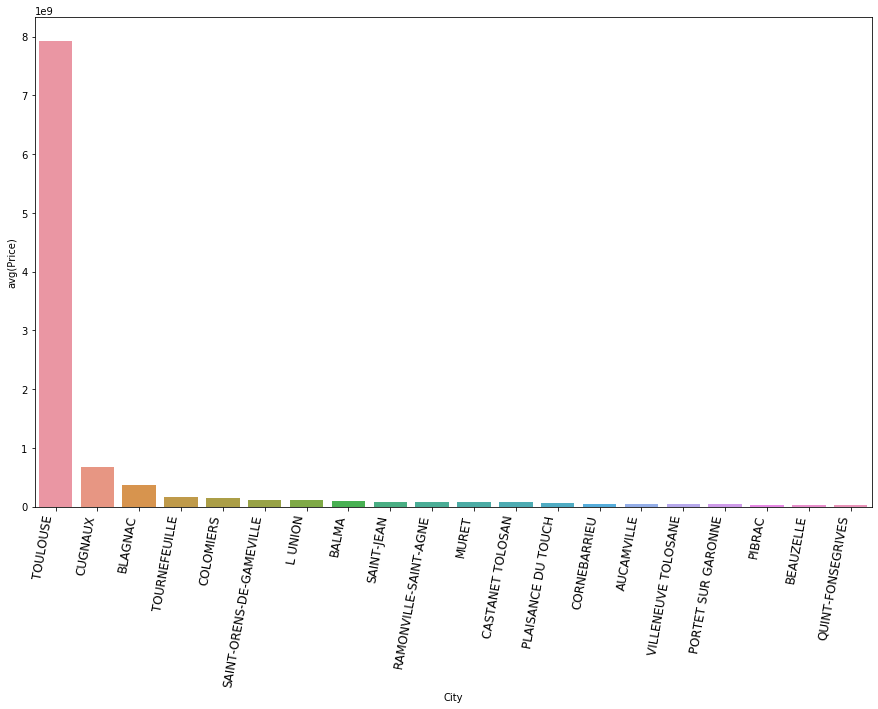

In [18]:
barchart1(gross_sales_city_2017.take(20))

### Average sales price in 2018

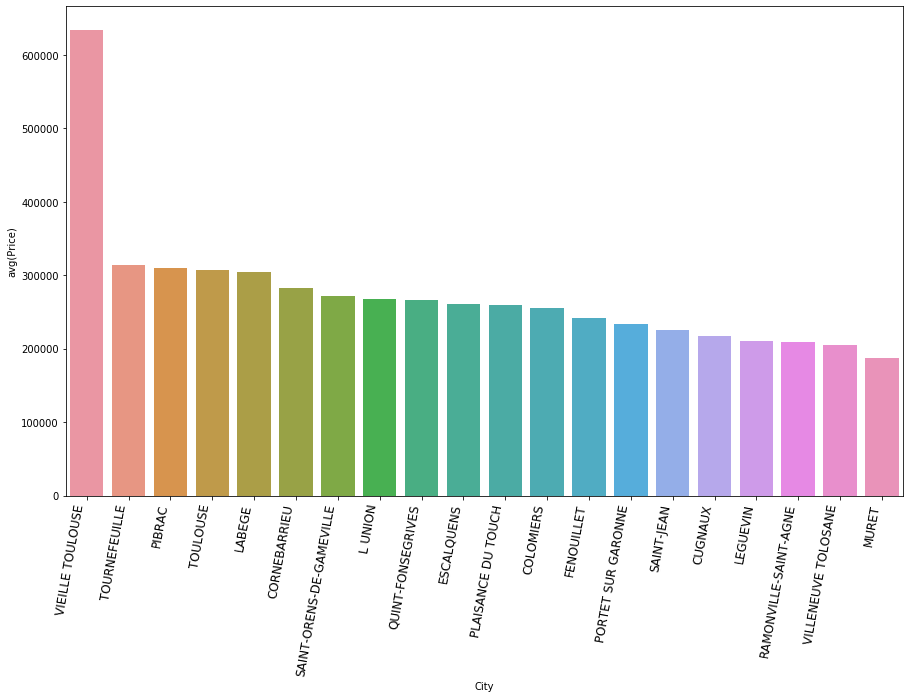

In [19]:
barchart1(avg_sales_city_2018.take(20))

In 2018, we can clearly observe that the average price of sales was the lowest for almost all the cities

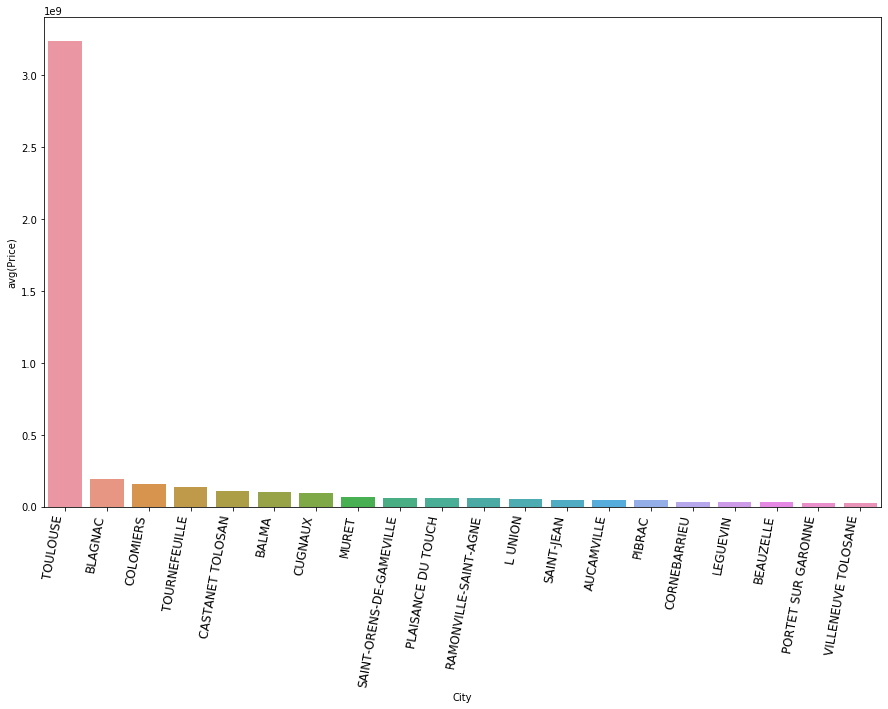

In [20]:
barchart1(gross_sales_city_2018.take(20))

### Average sales price in 2019

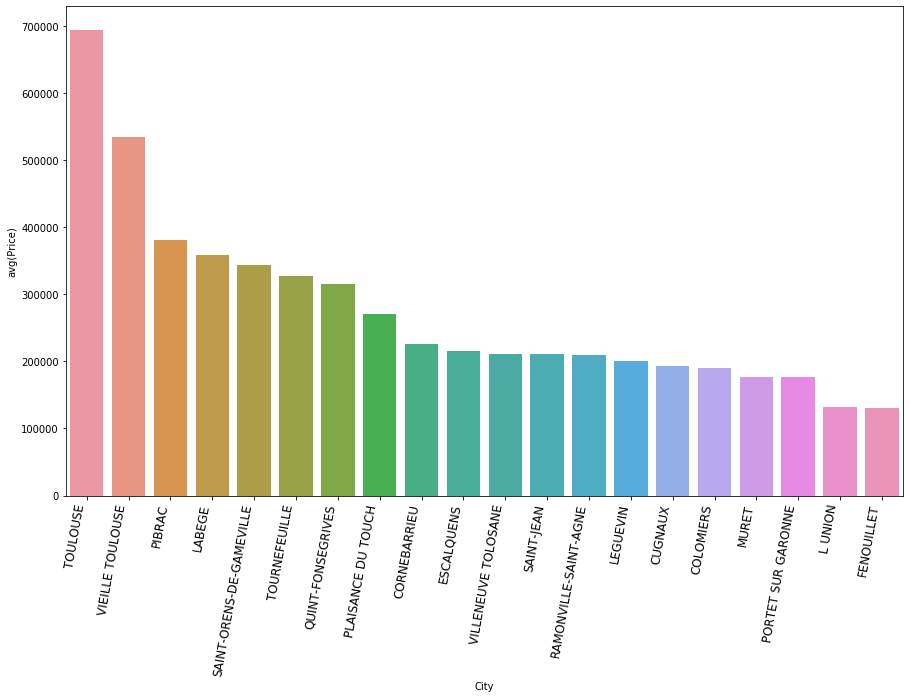

In [21]:
barchart1(avg_sales_city_2019.take(20))

There, we have the same trend with year 2018 but, Toulouse's average price increased alot

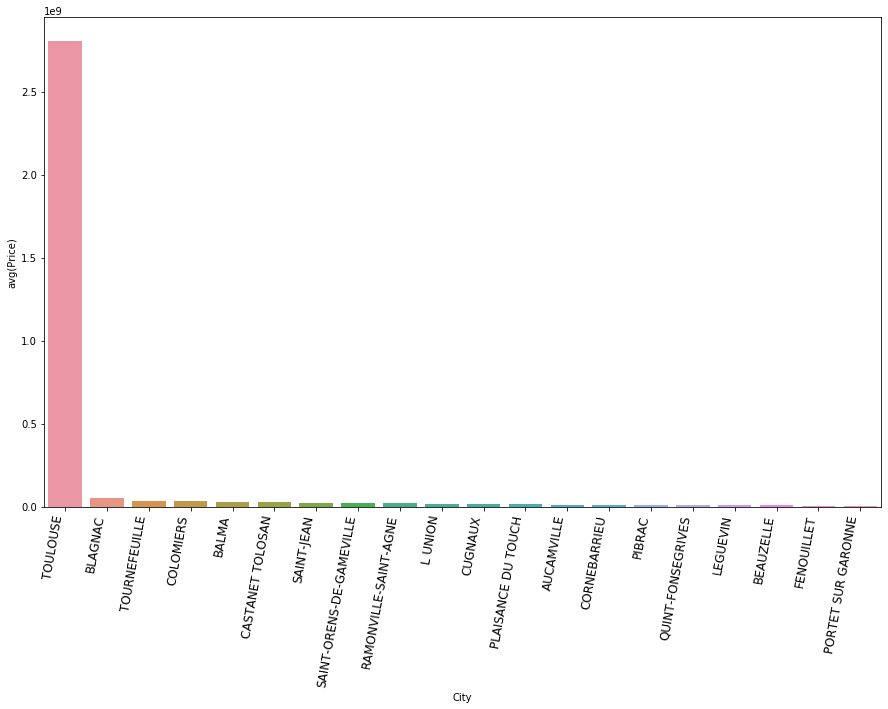

In [22]:
barchart1(gross_sales_city_2019.take(20))

The top 20 Cities for the five precedin year were then:

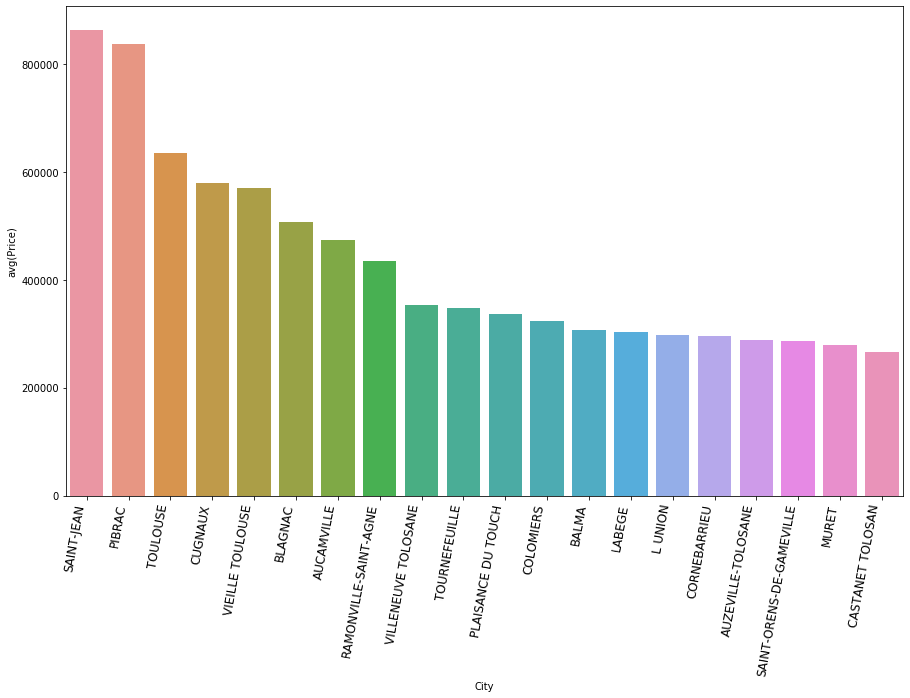

In [23]:
avg_sales_city = tls_hse.groupBy('City').agg({'Price':'avg'}).orderBy('avg(Price)', ascending=False)

avg_sales_city = avg_sales_city.take(20)
barchart1(avg_sales_city)

Now let's show the evolution of sales over the years for the TOP_20 Cities

We start by creating a pandas dataframe with the top cities

In [24]:
# what is the price_pm2 (average price per meter square) per City in descending order (order based on profit ratio) ?
import pyspark.sql.functions as f

price_pm2 = tls_hse.groupBy('City')\
                                         .agg(f.sum('Price')/f.sum('LivingArea'))\
                                         .withColumnRenamed('(sum(Price) / sum(LivingArea))', 'avg_price_pm2')\
                                         .orderBy('avg_price_pm2', ascending=False)

price_pm2.show()

+--------------------+------------------+
|                City|     avg_price_pm2|
+--------------------+------------------+
|          SAINT-JEAN| 10698.82545337161|
|            TOULOUSE|10431.477407458191|
|              PIBRAC| 8110.542615684013|
|             CUGNAUX| 7602.294282972824|
|             BLAGNAC| 7524.431391487357|
|          AUCAMVILLE| 7004.446201269821|
|RAMONVILLE-SAINT-...|   6058.9495972636|
| VILLENEUVE TOLOSANE| 4317.665923508786|
|           COLOMIERS| 4288.396009593455|
|       TOURNEFEUILLE| 4177.112150494479|
|  PLAISANCE DU TOUCH| 3592.695635714672|
|        CORNEBARRIEU|3588.4095704814067|
|    CASTANET TOLOSAN|3582.0651810352038|
|             L UNION|3541.7428817147393|
|SAINT-ORENS-DE-GA...|3524.3038432588496|
|               MURET| 3430.436860377632|
|               BALMA| 3427.787055810034|
|    VIEILLE TOULOUSE| 3179.570119521912|
|   QUINT-FONSEGRIVES|3135.5445000460504|
|           BEAUZELLE| 3120.003929838014|
+--------------------+------------

## Let's 

In [25]:

# Calculating the differences between prices by sale type
Differences_between_types_of_sales = tls_hse.groupBy('SaleType').agg({'Price':'sum'})
                                           

Differences_between_types_of_sales.show(10)

+--------------------+---------------+
|            SaleType|     sum(Price)|
+--------------------+---------------+
|                null|           null|
|SALE BEFORE COMPL...|  2.731476408E9|
|                SALE|3.9841859782E10|
+--------------------+---------------+



In [26]:
#Convert to Pandas df
df_Differences_between_types_of_sales= Differences_between_types_of_sales.toPandas()

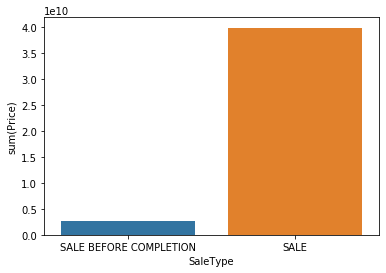

In [27]:
sb.barplot(x='SaleType',y='sum(Price)',data=df_Differences_between_types_of_sales)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C0C84F3908>],
      dtype=object)

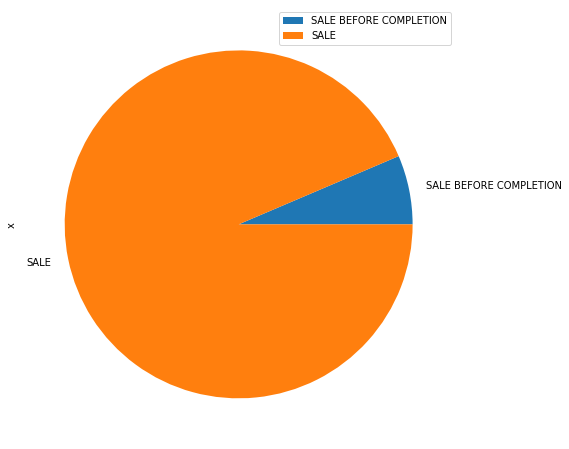

In [28]:
# --- dataset 1: just 4 values for 4 groups:
df = pd.DataFrame([2.731476408E9,3.9841859782E10], index=['SALE BEFORE COMPLETION', 'SALE'], columns=['x'])
 
# make the plot
df.plot(kind='pie', subplots=True, figsize=(8, 8))

More than 90% are using the standard sale mode

In [29]:
av_2015 = avg_sales_city_2015.toPandas()

In [30]:
av_2016 = avg_sales_city_2016.toPandas()
av_2017 = avg_sales_city_2017.toPandas()
av_2018 = avg_sales_city_2018.toPandas()
av_2019 = avg_sales_city_2019.toPandas()

In [31]:
av_2015.head()

,City,avg(Price)
0,VILLENEUVE TOLOSANE,6.671779e+05
1,VIEILLE TOULOUSE,5.636344e+05
2,TOURNEFEUILLE,2.528854e+05
3,TOULOUSE,1.141088e+06
4,SAINT-ORENS-DE-GAMEVILLE,2.158454e+05


In [32]:
df = av_2015
df['2015'] = av_2015['avg(Price)']
df['2016'] = av_2016['avg(Price)']
df['2017'] = av_2017['avg(Price)']
df['2018'] = av_2018['avg(Price)']
df['2019'] = av_2019['avg(Price)']

In [41]:
df.head(20)

,City,avg(Price),2015,2016,2017,2018,2019
0,VILLENEUVE TOLOSANE,6.671779e+05,6.671779e+05,273733.022388,2.622313e+05,204781.978261,210984.615385
1,VIEILLE TOULOUSE,5.636344e+05,5.636344e+05,599694.250000,5.110997e+05,634183.846154,534512.500000
2,TOURNEFEUILLE,2.528854e+05,2.528854e+05,535836.106529,2.906029e+05,313374.255760,326804.184466
3,TOULOUSE,1.141088e+06,1.141088e+06,443091.788670,6.081595e+05,306404.165249,694309.768241
4,SAINT-ORENS-DE-GAMEVILLE,2.158454e+05,2.158454e+05,224055.903010,4.106879e+05,271456.835498,343287.596491
5,SAINT-JEAN,3.168128e+06,3.168128e+06,224103.995816,2.918739e+05,225314.881188,210550.783784
6,RAMONVILLE-SAINT-AGNE,8.752919e+05,8.752919e+05,405046.909747,2.774992e+05,209570.574545,209334.619565
7,QUINT-FONSEGRIVES,2.164473e+05,2.164473e+05,294352.270588,2.598594e+05,265810.800000,314951.612903
8,PORTET SUR GARONNE,2.159394e+05,2.159394e+05,213923.813008,2.482156e+05,233571.528926,177012.500000
9,PLAISANCE DU TOUCH,5.942262e+05,5.942262e+05,226053.536364,2.416886e+05,259532.497758,270194.346939


In [ ]:
scale = alt.Scale(type="linear")
c_deces = (
        alt.Chart(df)
        .mark_line(point=True)
        .encode(
            alt.X("days_after_5_deaths"),
            alt.Y("deces", scale=scale),
            alt.Color("City"),
            tooltip=["days_after_5_deaths", "deces", "maille_nom"],
        )
        .interactive()
    )



c_deces


In [34]:
# what is the gross sales (sum of all sales) per City ?

gross_sales_city_df = tls_hse.groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)

gross_sales_city_df.show()

+--------------------+---------------+
|                City|     sum(Price)|
+--------------------+---------------+
|            TOULOUSE|3.1724699371E10|
|             BLAGNAC|  2.524100608E9|
|             CUGNAUX|  1.006232069E9|
|          SAINT-JEAN|   9.28005421E8|
|           COLOMIERS|   8.74356774E8|
|       TOURNEFEUILLE|   8.11805038E8|
|RAMONVILLE-SAINT-...|   5.49122602E8|
|          AUCAMVILLE|   4.56731919E8|
|              PIBRAC|   4.50102673E8|
|               BALMA|   4.10830562E8|
|               MURET|   3.78442364E8|
|    CASTANET TOLOSAN|    3.4270334E8|
|  PLAISANCE DU TOUCH|   3.32162675E8|
|SAINT-ORENS-DE-GA...|   3.13708858E8|
|             L UNION|   2.67684927E8|
| VILLENEUVE TOLOSANE|   2.13029319E8|
|        CORNEBARRIEU|   1.86722892E8|
|           BEAUZELLE|   1.30204004E8|
|            LEGUEVIN|   1.27386157E8|
|  PORTET SUR GARONNE|   1.23859407E8|
+--------------------+---------------+
only showing top 20 rows



In [35]:
# what is the count of sales types (sum of all sales) per region ?

count_saletype1_city = tls_hse.groupBy('City','SaleType').agg({'SaleType':'count'}).filter('SaleType = "SALE"').orderBy('count(SaleType)', ascending=False)

pos = count_saletype1_city.take(25)

In [36]:
# what is the count of sales types (sum of all sales) per region ?

count_saletype2_city = tls_hse.groupBy('City','SaleType').agg({'SaleType':'count'}).filter('SaleType != "SALE"').orderBy('City', ascending=False)

neg = count_saletype2_city.take(25)

In [37]:

def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], t[2]) for t in list_positives]
    list_2 = [(t[0], t[1], t[2]) for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    pd_df = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[2] for t in list_1 ],
     'polarity': [ t[1] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    pd_df['color'] = pd_df.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=pd_df, x='Opinion', y='Count', hue='polarity', palette=["blue", "red"], order=pd_df['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), pd_df['color']): 
        tick.set_color(color)
    
    plt.show()

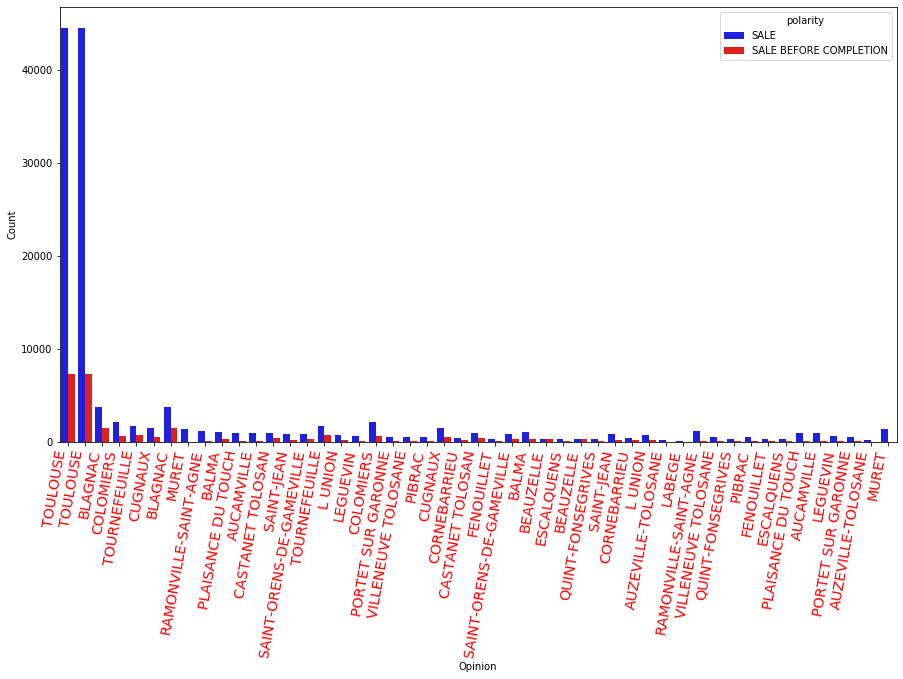

In [38]:
plot_opinion(pos,neg)

In red the cout oh house sold by "SALE BEFORE COMPLETION" and in blue; the remainings

In [39]:
# what is the gross sales (sum of all sales) per region ?

gross_sales_region_df = tls_hse.groupBy('City').agg({'Price':'sum'}).orderBy('sum(Price)', ascending=False)

gross_sales_region_df.show()

+--------------------+---------------+
|                City|     sum(Price)|
+--------------------+---------------+
|            TOULOUSE|3.1724699371E10|
|             BLAGNAC|  2.524100608E9|
|             CUGNAUX|  1.006232069E9|
|          SAINT-JEAN|   9.28005421E8|
|           COLOMIERS|   8.74356774E8|
|       TOURNEFEUILLE|   8.11805038E8|
|RAMONVILLE-SAINT-...|   5.49122602E8|
|          AUCAMVILLE|   4.56731919E8|
|              PIBRAC|   4.50102673E8|
|               BALMA|   4.10830562E8|
|               MURET|   3.78442364E8|
|    CASTANET TOLOSAN|    3.4270334E8|
|  PLAISANCE DU TOUCH|   3.32162675E8|
|SAINT-ORENS-DE-GA...|   3.13708858E8|
|             L UNION|   2.67684927E8|
| VILLENEUVE TOLOSANE|   2.13029319E8|
|        CORNEBARRIEU|   1.86722892E8|
|           BEAUZELLE|   1.30204004E8|
|            LEGUEVIN|   1.27386157E8|
|  PORTET SUR GARONNE|   1.23859407E8|
+--------------------+---------------+
only showing top 20 rows



In [40]:
# what is the gross sales (avg of all sales) per region ?

gross_sales_region_df = tls_hse.groupBy('City').agg({'Price':'avg'}).orderBy('avg(Price)', ascending=False)

gross_sales_region_df.show()

+--------------------+------------------+
|                City|        avg(Price)|
+--------------------+------------------+
|          SAINT-JEAN|  863260.856744186|
|              PIBRAC| 836622.0687732341|
|            TOULOUSE| 634151.5455853839|
|             CUGNAUX| 579626.7678571428|
|    VIEILLE TOULOUSE|          570051.5|
|             BLAGNAC|507254.94533762056|
|          AUCAMVILLE| 472807.3695652174|
|RAMONVILLE-SAINT-...|434089.01343873516|
| VILLENEUVE TOLOSANE| 353282.4527363184|
|       TOURNEFEUILLE|347073.55194527574|
|  PLAISANCE DU TOUCH|335517.85353535356|
|           COLOMIERS|323835.84222222224|
|               BALMA|306818.94100074685|
|              LABEGE| 303852.6934306569|
|             L UNION|297758.53948832036|
|        CORNEBARRIEU|296385.54285714286|
|  AUZEVILLE-TOLOSANE|289053.77040816325|
|SAINT-ORENS-DE-GA...|285969.78851412947|
|               MURET|279293.25756457564|
|    CASTANET TOLOSAN| 266280.7614607615|
+--------------------+------------

In [56]:
steve = avg_sales_city_2015.take(50)